<h1>Customer Analytics and Customer Insight</h1>
<h2>Conjoint Analysis on Preferences and Segments in the Portable Bluetooth Speaker Market</h2>

The purpose of this paper is to provide insights on customer preferences and to identify relevant customer segments within the category of Portable Bluetooth Speakers. To achieve this goal a choice based conjoint analysis will be conducted. The necessary data has been collected through an online survey by the Institute of Marketing of the Humboldt University. The survey consisted of two parts. The first one contained personal questions towards category knowledge and socio- demographics, the second one contained responses to the product choice sets. I start out with the conjoint analysis of the choice data set. The data set is effect coded, meaning the utilities sum up to zero within each attribute category.

<h3>Data Set and Model Estimation</h3>

In [31]:
#Load libraries and raw data set
library(gmnl)
library(mlogit)
library(ggplot2)
library(reshape2)
library(stringr)
library(rpart)
library(rpart.plot)
library(randomForest)
data.cbceffect<-read.csv('choiceData_590506.csv')
dim(data.cbceffect)
#rescale price so it corresponds to utility increase per 10$ price step.
data.cbceffect$price<-data.cbceffect$price/10
head(data.cbceffect)

[1] 14400    17

X,id,cs,alt,choice,none,price,battery1,battery2,battery3,battery4,weight1,weight2,weight3,sound1,sound2,sound3
97,11,1,1,0,0,7,0,1,0,0,1,0,0,0,0,1
98,11,1,2,0,0,15,1,0,0,0,0,0,1,1,0,0
99,11,1,3,1,0,11,0,0,1,0,1,0,0,-1,-1,-1
100,11,1,4,0,1,0,0,0,0,0,0,0,0,0,0,0
101,11,2,1,0,0,7,0,1,0,0,0,1,0,1,0,0
102,11,2,2,0,0,9,-1,-1,-1,-1,-1,-1,-1,0,1,0


A mixed logit model is used to estimate aggregated and individual preference parameters. One advantage of a mixed over a simple multinomial logit model is, that it allows for person specific preferences. This allows to cluster  respondents subsequently based on their preference estimates.


In [32]:
#transform categorical variables into dummy coding
data_ml_bluetooth_effect=mlogit.data(data.cbceffect, choice = "choice", shape = "long",
                                 id.var = "id", alt.var = "alt")
#Model Estimation
mxl_bluetooth <- gmnl(choice ~ 0 + none+price+battery1+battery2+battery3+battery4+
                    weight1+weight2+weight3+sound1+sound2+sound3, 
                  data = data_ml_bluetooth_effect, model = "mixl", correlation = FALSE, 
                  haltons = NULL, R = 2000, panel = TRUE, tol = 1e-12, print.level = 1,
                  ranp = c(none = "n", price = "n", battery1 = "n", battery2 = "n",battery3 = "n",battery4 = "n", 
                           weight1 = "n", weight2 = "n",weight3 = "n", sound1 = "n", sound2 = "n", sound3 = "n"))

I create a dataset with respondent specific preferences estimates.<br>
Individuals with positve price perferences seem implausible. Therefore I remove them from all relevant datasets.

In [ ]:
#create data set with respondent preference estimates
mxl_betai = effect.gmnl(mxl_bluetooth)$mean
mxl_betai = as.data.frame(mxl_betai)
indivData = read.csv('indivData_590506.csv')
#remove respondents with positive price coefs from all relevant data sets
indivData = indivData[which(mxl_betai$price < 0),]
choice_price_neg = data.cbceffect[data.cbceffect$id %in% indivData$id,]
mxl_betai<-subset(mxl_betai,mxl_betai[,2]<0)

write.csv(mxl_betai,file="ind_pref_price_neg.csv",row.names=FALSE)
write.csv(indivData, "indivData_sub_price_neg.csv", row.names = F)
write.csv(choice_price_neg, "effect_ml_pri_neg.csv", row.names = F)
head(mxl_betai)

Calculate Parth Worths for the ommited attribute levels.

In [33]:
ind_pref = read.csv("ind_pref_price_neg.csv")
cols = names(ind_pref)

add_ommited_pw = function(ind_pref, att_name, cols){
    #adds part worths(pw) for the ommited attribute levels to the preference dataframe
  attribute_cols = cols[grep(att_name, cols)]
  new_col_name =  paste0(att_name, as.character(max(grep("[0-9]", attribute_cols)) + 1))
  ind_pref[, new_col_name] =  0 - rowSums(ind_pref[,attribute_cols])
  return(ind_pref)
}  

for(att in c("battery", "weight", "sound")){
  ind_pref = add_ommited_pw(ind_pref, att, cols = cols)
}

PW = ind_pref[,3:15]
PW = PW[, order(names(PW))]
PW = cbind(ind_pref[,1:2], PW)
head(PW)

none,price,battery1,battery2,battery3,battery4,battery5,sound1,sound2,sound3,sound4,weight1,weight2,weight3,weight4
-12.4370428,-0.56168985,-1.6588656,-0.2015096,0.1884520,0.5537557,1.1181675,-3.0833268,-0.4324235,0.9010875,2.6146628,0.7376991,0.2381162,-0.09342943,-0.8823858
-12.4982362,-0.64491141,-0.7408493,-0.2046929,0.2118804,0.5534250,0.1802369,-2.8379613,-0.3882430,0.9713326,2.2548717,0.4516939,0.1587443,0.04016417,-0.6506024
-10.5555664,-0.05169533,-1.3462516,-0.1926465,0.2096073,0.5834711,0.7458196,-3.4474058,-0.8067364,0.8953400,3.3588023,0.7291077,0.3308254,-0.02169741,-1.0382357
-5.1263237,-0.36217551,-1.3481889,-0.2574588,0.2076824,0.5167001,0.8812652,-2.9199103,-0.8453724,1.0041165,2.7611662,0.6833427,0.4968326,0.02483880,-1.2050141
-13.2687279,-0.74194118,-1.6332140,-0.1998363,0.1576263,0.5582876,1.1171364,-1.4741027,-0.2798607,0.9185096,0.8354537,1.0632011,0.2196911,-0.11231526,-1.1705769
0.4547102,-0.21835404,-1.6371675,-0.2615920,0.2387926,0.6802894,0.9796775,-0.8796407,-0.2930464,0.8626974,0.3099897,0.8795875,0.3352366,-0.23511110,-0.9797130


Calcualte the percentual importance of the different attribute categories for each respondent.

In [34]:
#scale price coef to represent utilitz change per 10 USD price change
price.imp = 80/10 * abs(ind_pref$price)
importance = data.frame(price.imp)

cols = names(ind_pref)
for(att in c("battery", "weight", "sound")){
  attribute_cols = cols[grep(att, cols)]
  range_name = paste0(att, '.imp')
  importance[,range_name] = apply(ind_pref[,attribute_cols],1,function(x) abs(max(x) - min(x)))
}

rs = rowSums(importance)
rel.imp = apply(importance,2, function(x) x/rs)
rel.imp = data.frame(rel.imp)

ind_pref = cbind(ind_pref, rel.imp)
head(rel.imp)

price.imp,battery.imp,weight.imp,sound.imp
0.30801521,0.1903560,0.11105123,0.3905775
0.40789120,0.1023247,0.08714704,0.4026370
0.03732789,0.1888290,0.15951925,0.6143239
0.22820869,0.1755988,0.14873294,0.4474595
0.44586906,0.2066027,0.16779843,0.1797298
0.21930483,0.3285300,0.23342458,0.2187406


Calculate Willingness to pay for different attributes levels e.g. how much less would a respondent pay for a lower attribute level.

In [9]:
for(att in c("battery", "weight", "sound")){
  attribute_cols = cols[grep(att, cols)]
  
  for(col in attribute_cols){
    #get WTP per column by deviding through ommited column and multiplying with price coef
    col_WTP = (ind_pref[,col] - ind_pref[,attribute_cols[length(attribute_cols)]]) * abs(ind_pref$price) * 10
    
    wtp_name = paste0(col, ".WTP")
    ind_pref[,wtp_name] = col_WTP
  }
  
  
  range_name = paste0(att, '.imp')
  importance[,range_name] = apply(ind_pref[,attribute_cols],1,function(x) abs(max(x) - min(x)))
}

WTP = ind_pref[,names(ind_pref)[grep("WTP", names(ind_pref))]]
#WTP = cbind(clust = ind_pref$clust, WTP)
head(WTP)

battery1.WTP,battery2.WTP,battery3.WTP,battery4.WTP,battery5.WTP,weight1.WTP,weight2.WTP,weight3.WTP,weight4.WTP,sound1.WTP,sound2.WTP,sound3.WTP,sound4.WTP
-15.598313,-7.4124923,-5.2221176,-3.17024373,0,9.099853,6.2937463,4.4314881,0,-32.005029,-17.115174,-9.624979,0
-5.940190,-2.4824559,0.2040725,2.40673269,0,7.108835,5.2195692,4.4548325,0,-32.844261,-17.045748,-8.277690,0
-1.081503,-0.4851432,-0.2771967,-0.08392663,0,0.913634,0.7077407,0.5255028,0,-3.518492,-2.153389,-1.273495,0
-8.074537,-4.1241794,-2.4395517,-1.32036525,0,6.839166,6.1636716,4.4542258,0,-20.575468,-13.061999,-6.363603,0
-20.405982,-9.7711632,-7.1190010,-4.14632961,0,16.573319,10.3149708,7.8516791,0,-17.135550,-8.274977,0.616226,0
-5.713987,-2.7103622,-1.6177522,-0.65372606,0,4.059858,2.8712454,1.6258683,0,-2.597606,-1.316754,1.206860,0


<h3>Clustering and Segment preferences</h3>
To identify homogeneous customer segments one has to define, how similarity between customers should be measured, e.g. which measurements should be included to calculate distances between them. While part worths are on an interval scale, the price parameters corresponds to the utility change per 10 Dollar difference and the ’None’ parameter describes the absolute utility when the ’None’ option is selected. To make these scales comparable I normalize each parameters by subtracting its mean and dividing it through its variance. While this makes the scales comparable, it also means that differences within every each feature are weighted equally, e.g. differences within the price parameter have the same influence on respondents similarities as differences in one of the weight parameters. To account for the fact that features may differ within their absolute impact on a customers utility I also include the normalized importance measurements in the cluster data set.

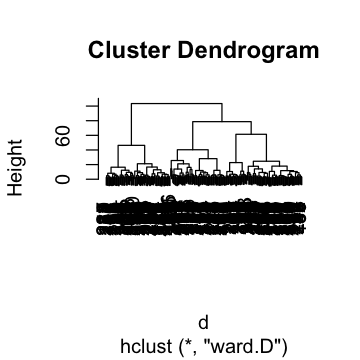

clust
 1  2  3  4 
95 81 32 81 

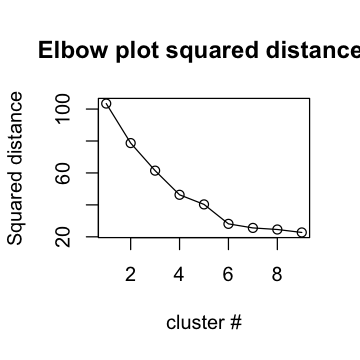

In [10]:
options(repr.plot.width=3, repr.plot.height=3)
clust_df = scale(cbind(PW, rel.imp))
d= dist(clust_df)

hc = hclust(d, method = "ward.D")
plot(hc)

plot(hc$height[288:280]~seq(1:9), main = "Elbow plot squared distance ", ylab = "Squared distance", xlab = "cluster #")
lines(hc$height[288:280]~seq(1:9))

clust = cutree(hc, 4)
table(clust)
#plot_grid(plot.imp, plot.mds, scale = 0.8)

Several clustering methods (kmeans, hierarchical) and linkage criteria (single, complete, Wards) are tested. The selection criteria for the most appropriate method was a high decrease of between cluster distance at a low cluster count and the interpretability of the resulting segments. The later was assessed by analysing the relative importance and willingness to pay of the clusters. Hierarchical clustering with Ward’s method has shown to produce the best results. The ”elbow plot” the between cluster distance decreases between two and four cluster almost similar and becomes then flatter. The visual analysis on the importance measures have been conducted on the segment means and on a 2-dimensional visualization of the importance measures. For the later multidimensional scaling and property fitting of the importance parameters was used.

In [35]:
names(rel.imp) = c("Price","Battery","Weight", "Sound")

ri = split(rel.imp, clust)
cl.imps = sapply(ri, colMeans)
imp.pl = melt(cl.imps)
names(imp.pl) = c("Attribute", "Segment", "Relative Importance")
library(plyr)
imp.pl$Segment = mapvalues(imp.pl$Segment,c(1,2,3,4), c("Prem Sound",
                                         "Basic Sound",
                                         "Prem All-Round",
                                         "Basic Flexible"))


plot.imp = ggplot(imp.pl, aes(x = Segment, y = `Relative Importance`, fill = Attribute))+
  geom_bar(stat="sum")  +scale_size(guide=FALSE)

###### MDS IMP
mds = cmdscale(dist(rel.imp))
profit = lm(cbind(Price,Battery,Weight,Sound) ~  mds[,1] + mds[,2] -1, data = rel.imp)

a = coef(profit)[1, ]
b = coef(profit)[2, ]

mds_df = data.frame(mds, Segment = clust)

mds_df$Segment = mapvalues(mds_df$Segment,c(1,2,3,4), c("Premium Sound",
                                                        "Basic Sound",
                                                        "Premium All-Round",
                                                        "Basic Flexible"))
arrow_df = data.frame(xstart = rep(0,4), ystart = rep(0,4), xend = 0.3*a, yend = 0.3 *b)


plot.mds = ggplot(mds_df, aes(X1, X2)) + geom_point(aes(col=Segment)) +
    geom_segment(data = arrow_df, 
                 aes(x = xstart, xend = xend, y = ystart,yend = yend),
                 arrow=arrow(length=unit(2, "mm"))) +
    geom_text(data=arrow_df, aes(label=names(rel.imp),
                                 x=xend ,
                                 y= yend +c(-0.02,0.02,0.02,-0.02), size = 4))+scale_size(guide=FALSE)


Warning message:
“package ‘cowplot’ was built under R version 3.4.3”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



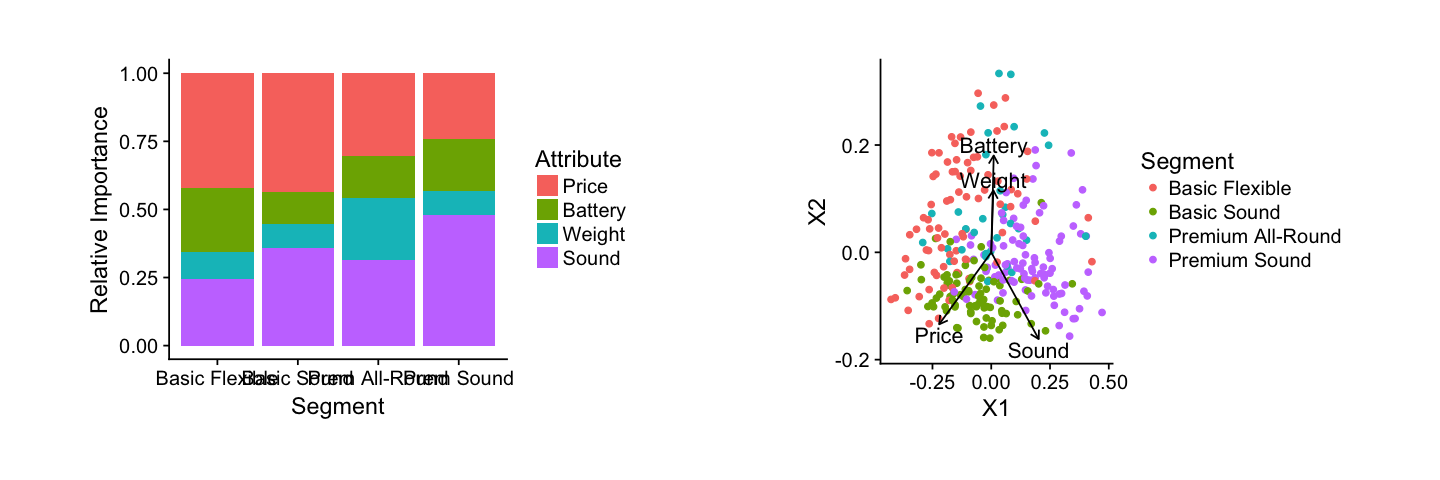

In [36]:
library("cowplot")
library(repr)
options(repr.plot.width=12, repr.plot.height=4)
plot_grid(plot.imp, plot.mds, scale = 0.8)

**Qualitative Importance Analysis in order to find the most appropriate cluster method**<br>
The two dimensional importance map with four clusters shows a clear separation of three main clusters between the fitted importance vectors. The members of the forth clusters are mainly defined by a common preference for weight and battery power, while they are otherwise spread along the other dimensions. This property and the small cluster size could imply that three clusters are favourable. However, without a fourth cluster the over all cluster mixture is significantly higher. It is notable, that three of the four importance dimensions are clearly separated. Yet the direction of the weight and the battery importance are almost identical. One can conclude that people who value a light speaker also care about battery power. The identified clusters are named according to their attibute importances.

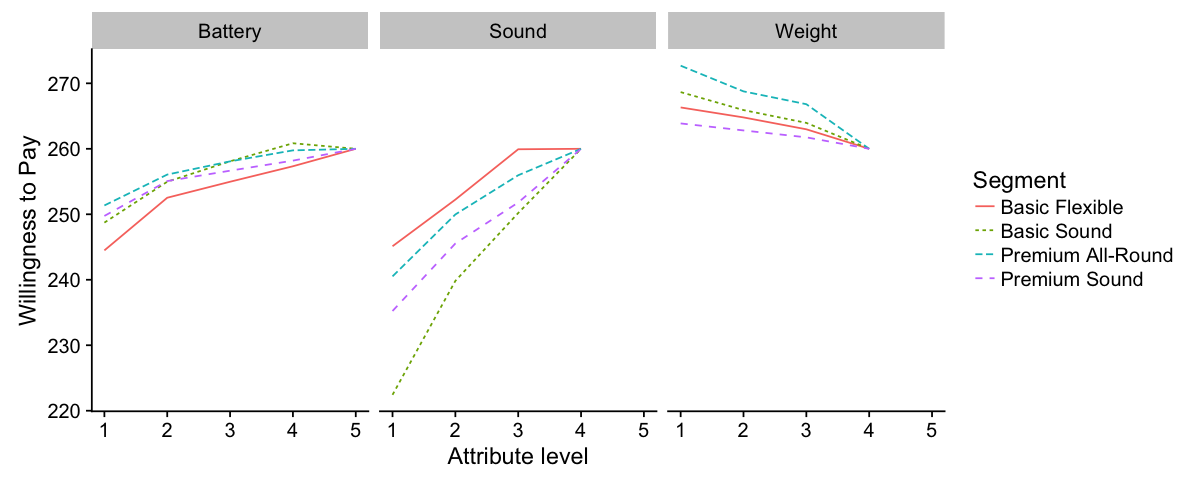

In [37]:
###### plot WTP
options(repr.plot.width=10, repr.plot.height=4)
WTP = WTP + 130

lWTP = split(WTP, clust)
cl.wtp = sapply(lWTP, colMeans)
wtp.pl = melt(cl.wtp)


X <-regmatches(wtp.pl$Var1, gregexpr("[[:digit:]]+", wtp.pl$Var1))
X = as.numeric(unlist(X))


wtp.pl = cbind(X, wtp.pl)
names(wtp.pl)[2:3] = c("level", "cluster")
wtp.pl$level = as.character(wtp.pl$level)
wtp.pl$level =  str_replace_all(wtp.pl$level, "[[:digit:]].*", "")
wtp.pl$level = paste0(toupper(substr(wtp.pl$level, 1,1)), substr(wtp.pl$level, 2,nchar(wtp.pl$level)))
wtp.pl$cluster = mapvalues(wtp.pl$cluster,c(1,2,3,4), c("Premium Sound",
                                                        "Basic Sound",
                                                        "Premium All-Round",
                                                        "Basic Flexible"))

names(wtp.pl) = c("Attribute level", "level", "Segment", "Willingness to Pay")

ggplot(wtp.pl, aes(x = `Attribute level`, y = `Willingness to Pay`, col = Segment)) +
  geom_line(aes(linetype = Segment)) +
  facet_grid(.~level)

**Willingness to pay for different attribute levels and market segments.** <br> The WTP of a product with the highest attribute levels is defined as zero. For illustrative purposes I shifted its value to 130, since negative monetary values seem counter intuitive. The different attribute levels are decoded from one to five/four on the x-axis,  representing the lowest to the highest levels. In consistence with the importance analysis, the potential for price increases through a better sound quality is about twice as high as for the other two attributes. When comparing a stimuli with the lowest attribute levels against the highest ones the maximum WTP difference lies roughly between 30 and 40 Dollar, depending on the segments. This seems rather low considering that the price range in the survey was 80 Dollar. Depending on improvement costs between the attribute levels, this could imply that producing lower quality speakers might be more economic for a company. Especially when looking at the battery attribute, the WTP increase from a 8 hour battery to a 10 hours is clearly higher than between the higher attribute levels. The active base users are not even willing to pay more for a battery that lasts 12 hours than for one that lasts 10 hours and the base sound enthusiasts even prefer the 10 hour battery. I refrain from removing the corresponding respondents due to this implausibility since the effect is small and real world choices might show such inconsistencies as well.

<h3> Market Shares </h3>
In order to give an inspiration on how this results can be used for new product development, I create four example product profiles tailored to the preferences of the identified segments. Since production costs are unknown the underlying assumption is a simple trade off between attribute quality and price. The example profiles are used to calculate the utility for every customer segment and for the full market. These utilities are subsequently used to predict market shares with a logit model.

In [38]:
#clust 1
prodA = c(0,15, #highest price
          0,0,1,0, #medium battery
          0,0,0, #heaviest
          0,0,0) #best sound

#clust 2
prodB = c(0,10, #low price
          1,0,0,0, #shortest battery
          0,0,0, #heaviest          
          0,0,1) #2 best sound

#clust 3
prodC = c(0,13, #medium high price
          0,1,0,0, # 2nd shortest battery
          1,0,0, #lightest
          0,1,0) #3nd best sound

#clust 4
prodD = c(0,8, #low price
          0,0,1,0, # 2nd best battery
          0,0,0, #heaviest          
          1,0,0) #worst sound

none = c(1,rep(0,11))

products = as.matrix(rbind(prodA, prodB, prodC,prodD,none))
products

prodA,0,15,0,0,1,0,0,0,0,0,0,0
prodB,0,10,1,0,0,0,0,0,0,0,0,1
prodC,0,13,0,1,0,0,1,0,0,0,1,0
prodD,0,8,0,0,1,0,0,0,0,1,0,0
none,1,0,0,0,0,0,0,0,0,0,0,0


To calculate utilities for the product profiles I change the effect coding to regular dummy coding. Thus the dependent variable in the regression will represents the absolut utility measure (in effect coding the summed up utility of each attribute group was set to zero). I then re-estimate the mixed logit model for preference estimation for the full data set and each segment.

In [39]:
#change effect coded raw data to regular dummy coding
choice = read.csv("effect_ml_pri_neg.csv")

left = choice[,1:4]
choice = choice[,5:16]
choice[choice == -1] = 0 
dummy1 = cbind(left,choice)

dummy = mlogit.data(dummy1, choice = "choice", shape = "long",
                    id.var = "id", alt.var = "alt")
head(dummy)

,id,cs,alt,choice,none,price,battery1,battery2,battery3,battery4,weight1,weight2,weight3,sound1,sound2,sound3
1.1,11,1,1,FALSE,0,7,0,1,0,0,1,0,0,0,0,1
1.2,11,1,2,FALSE,0,15,1,0,0,0,0,0,1,1,0,0
1.3,11,1,3,TRUE,0,11,0,0,1,0,1,0,0,0,0,0
1.4,11,1,4,FALSE,1,0,0,0,0,0,0,0,0,0,0,0
2.1,11,2,1,FALSE,0,7,0,1,0,0,0,1,0,1,0,0
2.2,11,2,2,FALSE,0,9,0,0,0,0,0,0,0,0,1,0


Reestimate the mixed logit model for each market segment and the full market.

In [40]:
#assigne the respondent id as name to each cluster value
indiv = read.csv('indivData_sub_price_neg.csv')
names(clust) = indiv$id

#create list with respondents per cluster
clust.dum = list()
clust.dum[[1]] = dummy
clust.dum[[2]] = dummy[dummy$id %in% names(clust[clust==1]),]
clust.dum[[3]] = dummy[dummy$id %in% names(clust[clust==2]),]
clust.dum[[4]] = dummy[dummy$id %in% names(clust[clust==3]),]
clust.dum[[5]] = dummy[dummy$id %in% names(clust[clust==4]),]

#estimate cluster preferences and write them to a matrix
params.dum = matrix(ncol = 12, nrow = 5)
for(i in 1:5){
  mxl_bluetooth <- gmnl(choice ~ 0 + none+price+battery1+battery2+battery3+battery4+
                          weight1+weight2+weight3+sound1+sound2+sound3, 
                        data = clust.dum[[i]], model = "mixl", correlation = FALSE, 
                        haltons = NULL, R = 2000, panel = TRUE, tol = 1e-12, print.level = 1,
                        ranp = c(none = "n", price = "n", battery1 = "n", battery2 = "n",battery3 = "n",battery4 = "n", 
                                 weight1 = "n", weight2 = "n",weight3 = "n", sound1 = "n", sound2 = "n", sound3 = "n"))
  
  params.dum[i,] = mxl_bluetooth$coefficients[1:12]
  
}

params.dum = as.data.frame(params.dum)
names(params.dum) = names(dummy[,5:ncol(dummy)])
row.names(params.dum) = c("full","1","2","3","4")
write.csv(params.dum, "dummy_parameter.csv", row.names = T)

A segments utility from a given product is caluclated by forming the vector product between its preference parameter and the product attribut values. A logit model is used to calulate the market shares in each segment.

In [41]:
params.dum = read.csv("dummy_parameter.csv", row.names = 1)

#calculate utilities per segment based on product attributes and preferences
util = products %*% t(params.dum)
util.exp = exp(util)
share = matrix(data = NA, nrow = nrow(products), ncol = 5)

#use logit model to estimate market shares
for(cl in 1:ncol(share)){
  for(p in 1:nrow(share)){
    util.p = util.exp[p,cl]
    util.tot = sum(util.exp[,cl])
    share[p,cl] = util.p/util.tot
  }
}

#Fromat restult data frame
percent <- function(x, digits = 2, format = "f", ...) {
  paste0(formatC(100 * x, format = format, digits = digits, ...), "%")
}

share.displ = matrix(percent(share), ncol = ncol(share), nrow = nrow(share))
prod2 = data.frame(Price = c(150,100,130,80,0),
                   Battery = c( "12 h","8 h","10 h","12 h ", "-"),
                   Sound = c(5,4.5,4,3.5,0),
                   Weight = c("700 g", "700 g", "400 g", "700 g","-"))
marketshare = cbind(prod2, share.displ)

names(marketshare)[5:9] = c("Full", "Premium Sound","Basic Sound", "Premium All-Round","Basic Flexible")
row.names(marketshare) = row.names(products)
marketshare

,Price,Battery,Sound,Weight,Full,Premium Sound,Basic Sound,Premium All-Round,Basic Flexible
prodA,150,12 h,5.0,700 g,30.23%,90.00%,2.89%,3.35%,3.81%
prodB,100,8 h,4.5,700 g,37.03%,7.40%,66.75%,5.39%,9.90%
prodC,130,10 h,4.0,400 g,17.56%,2.13%,2.77%,83.98%,8.50%
prodD,80,12 h,3.5,700 g,12.18%,0.39%,2.44%,2.11%,76.01%
none,0,-,0.0,-,3.00%,0.08%,25.15%,5.17%,1.79%


The table gives an overview of the stimuli derived from the prior analysis and the market share estimations. The fact that each product clearly dominates the corresponding segment points out, that the clustering approach was successful. Moreover the low share of the ’None” option in all but the Basic Sound segment is promising for the industry. However one should notice that stated preference data tends to be overly optimistic. Interestingly product B has the smallest value in its own segment ( 66,76 %). Yet it has the highest market share in the full sample ( 37,03 %). This implies the stimuli itself has a favourable price - quality ratio. Considering this and the outstanding share of the ’None’ option, the Basic Sound Enthusiasts might not be the best targeting choice.

<h3>Customer Charactersitics per Segment</h3>
The analysis of the individual customer data focuses on the question, how the segments can be described using customer characteristics and wheather they might be used to identify segment membership.
<h4>Dataset</h4>
The individual data set contains, after removing additional label decoding, 32 columns per respondent. Apart from the respondent id and two dummy variables stating whether the respondent owns or plans to buy a bluetooth speaker the remaining columns can be categorized like this: five features each on subjective domain knowledge and product category involvement (PII) both on a scale from one to seven, four features with stated relative attribute importances in percentage and five socio-demographic features on a categorical scale.
<h4>Sample Biases</h4>
The summary shows the most frequent levels for the socio-demographic features. Clearly the sample is not independent identically distributed from the full German bluetooth speaker market: About half of the respondents do not live in Germany, yet on an in- ternational scale German residents are over represented. Since statistical interference becomes impossible for very small observation counts, I assign all residence level with less than five occurrences with a name called ’other’. Similar biases occur in the other
 Marc-Andre Scheu - 590506 5
socio-demographic variables, except for the gender variable. However, this was foreseeable since respondents were non randomly selected by students of a German masters course. Thus students are as well over represented as the higher educational levels, younger age groups and low income classes. It is hard to predict how this affects the analysis results. If preference parameters are fairly independent from social-demographics the sample results might still be a good estimation for population preferences.

In [42]:
indiv = read.csv("indivData_sub_price_neg.csv")
summary(indiv)[,c(28,30,31,33,35,37)]

               GenderLabel     AgeLabel           Residence  
 Prefer not to answer:  6   25-29  :117   Germany      :167  
 female              :127   18-24  :115   Turkey       : 21  
 male                :156   30-34  : 20   Belgium      : 11  
                            >=50   : 19   France       : 11  
                            35-39  :  8   United States:  8  
                            45-49  :  4   Saudi Arabia :  7  
                            (Other):  6   (Other)      : 64  
      OccupationLabel               EducationLabel         IncomeLabel
 Employed     : 94    Graduate             :124    501-1000<80>  :95  
 Retired      :  2    High school          : 61    <500<80>      :52  
 Self-employed: 21    Less than high school:  4    1001-1500<80> :42  
 Student      :163    Other                :  4    rather not say:39  
 Unemployed   :  9    Undergraduate        : 96    >=3001<80>    :24  
                                                   1501-2000<80> :17  
       

<h4>Create aggregate measures</h4>
There are too many variables in the data to analize them individually. However it also promises little informational gain, because the variables within each category are strongly related. All product category involvement variables rate the subjective importance of bluetooth speakers. They only differ within their wording. For people unfamiliar with scales of customer involvement they seem synonymous. In fact all five variables are strongly correlated. The same is true for the subjective knowledge variables. I therefore create aggregate varibales which then can be used to describe the identified segments.

In [43]:
#replace Residence that occures less than 5 times with "other" category
rep.idx = names(table(indiv$Residence))[table(indiv$Residence)<5]
indiv$Residence = as.character(indiv$Residence)
indiv$Residence[indiv$Residence %in% rep.idx] = "other"
indiv$Residence = as.factor(indiv$Residence)

indiv$Income = ifelse(indiv$Income == 8,-1,
                  ifelse(indiv$Income==1, 500,
                  ifelse(indiv$Income==2,1000,
                  ifelse(indiv$Income==3,1500,
                  ifelse(indiv$Income==4,2000,
                  ifelse(indiv$Income==5,2500,
                  ifelse(indiv$Income==6,3000,3500)))))))

indiv$BrandAwareness_None = as.factor(indiv$BrandAwareness_None) 
indiv$avgBrandAvereness = rowSums(indiv[, 4:11])/8
indiv$avgSubjKnow = rowMeans(indiv[,13:17])
indiv$avgPII = rowMeans(indiv[,18:22])
#imp.diff = indiv[,23:26]/100 - rel.imp

indiv$CorImp_battery =  cor(indiv$RelImp_battery, rel.imp$Battery)
indiv$CorImp_weight = cor(indiv$RelImp_weight, rel.imp$Weight)
indiv$CorImp_sound = cor(indiv$RelImp_sound, rel.imp$Sound)
indiv$CorImp_price = cor(indiv$RelImp_price, rel.imp$Price)

indiv$clust = factor(clust, labels = c("Premium Sound", "Basic Sound", "Premium Alround", "Basic Flexible"))


Own = tapply(indiv$Own, indiv$clust, mean)
PlanToBuy = tapply(indiv$IntentToBuy, indiv$clust, mean)
BA = indiv[,4:11]

ModBrand = sapply(split(indiv[,4:11], indiv$clust), function(x) names(x)[which.max(colSums(x))])
AvgBrandAware = tapply(indiv$avgBrandAvereness, indiv$clust, mean)
AvgSubjKnow = tapply(indiv$avgSubjKnow, indiv$clust, mean)
AvgPII = tapply(indiv$avgPII, indiv$clust, mean)
Isfemale = tapply(indiv$GenderLabel, indiv$clust, function(x) mean(as.character(x)=='female' ))
AgeGr = tapply(indiv$AgeLabel, indiv$clust, function(x) names(which.max(table(x))))
Education = tapply(indiv$EducationLabel, indiv$clust, function(x) names(which.max(table(x))))
#tapply(indiv$OccupationLabel, indiv$clust, function(x) names(which.max(table(x))))

Income2 = ifelse(indiv$Income == -1,-1,
                      ifelse(indiv$Income== 500,250,
                             ifelse(indiv$Income==1000,750,
                                    ifelse(indiv$Income==1500,1250,
                                           ifelse(indiv$Income==2000,1750,
                                                  ifelse(indiv$Income==2500,2250,
                                                         ifelse(indiv$Income==3000,2750, 4000)))))))
AvgIncome = tapply(Income2, indiv$clust, function(x) mean(x[x>0]))

indOV = data.frame(Own, PlanToBuy,ModBrand, AvgBrandAware,AvgSubjKnow, AvgPII, Isfemale,AgeGr, Education, AvgIncome)
indOV[, sapply(indOV, is.numeric)] = round(indOV[, sapply(indOV, is.numeric)],2)
indOV

,Own,PlanToBuy,ModBrand,AvgBrandAware,AvgSubjKnow,AvgPII,Isfemale,AgeGr,Education,AvgIncome
Premium Sound,0.56,0.34,BrandAwareness_Bose,0.39,3.96,4.52,0.36,25-29,Graduate,1493.83
Basic Sound,0.37,0.33,BrandAwareness_Bose,0.38,3.68,4.21,0.42,18-24,Undergraduate,858.70
Premium Alround,0.44,0.16,BrandAwareness_Bose,0.35,3.68,4.29,0.44,18-24,Undergraduate,1387.93
Basic Flexible,0.35,0.36,BrandAwareness_Bose,0.33,3.61,3.98,0.56,25-29,Graduate,1274.65


The Table contains summary statistics for the individual variables and seg- ments. For categorical data the modus is used, variables which had the same modus in all segments such as occupation have been omitted. Binary variables present the rate of ”true” responses. Brand awareness is the rate of known brands out of eight in the survey. Subjective knowledge and category involvement are averaged over the respective five ratings. Average incomes have been estimated by assigning the category mean to each category observation and averaging over the segments. The highest income group has been assumed to have an average income of 4000 Dollar, respondents without reply have been omitted.
Within the two premium segments more people own a speaker than in the basic segments. This shows that first time customers are less willing to spent a lot of money. The rates of people who plan to buy a speaker are similar in all but the Premium All-Round segment. Due to this small rate and its overall small size I’d advise practitioners against targeting it. Brand awareness subject knowledge and category involvement all show the same pattern. The Premium Sound Enthusiasts show the highest values, Basic Sound Enthusiasts and Premium All-Round User are in the middle, and Basic Flexible Users show the smallest values. The ”Is female” variable has the opposite pattern indicating that man are generally more interested and educated in the field and willing to spent more money on speakers. The modi of age group and education yield little insight because they are simply the most common levels in the sample. As one would expect the premium segments have the highest Income and Basic Sound Enthusiasts have the smallest.

<h4>Decission Tree</h4>

In order to find out which customer characteristics are the best predictors for segment membership a decision tree is used. A decision tree splits the data starting from the full data set in the initial node iteratively into two child nodes. It selects the feature which maximizes the heterogeneity between the resulting nodes as split criterion. In our case the heterogeneity refers to differences to occurrence rates of the four segments. The al- gorithm could be continued until perfect classification is achieved or no splitting criteria remain. If a individual variable has a major impact on class membership which has been concealed through aggregation before, the variable would be selected as a early splitting criterion on the tree.

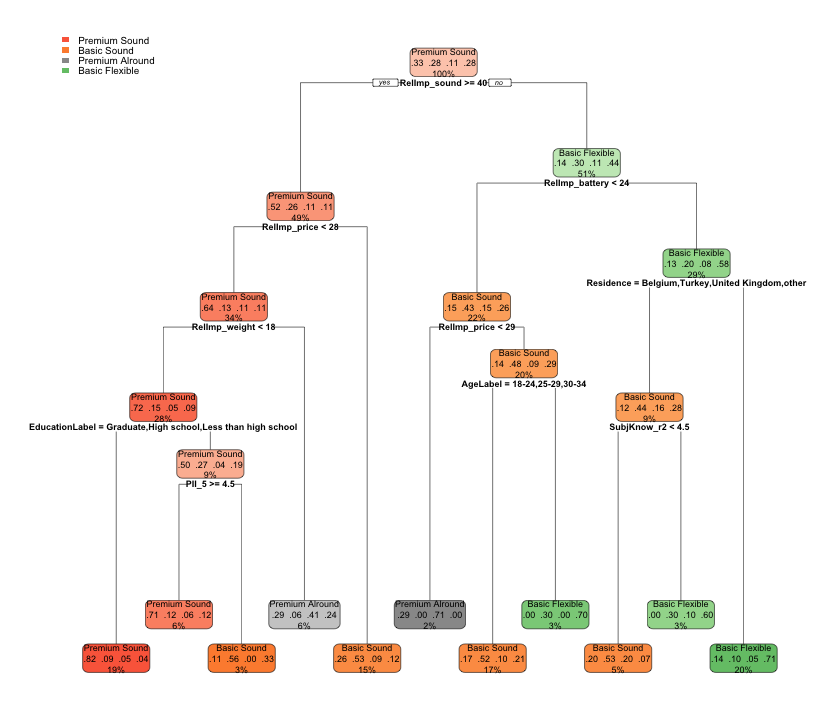

In [44]:
options(repr.plot.width=7, repr.plot.height=6)
#choose possible splitting criteria(no ids/ labels)
relv.col = c(2:26,28,30,31,32,33,35,36,38:45)
dtest = indiv[,relv.col]

#Train model plot trees
DT = rpart(clust ~ . , data = dtest)
rpart.plot(DT)

When building a tree on the full individual data set the first five splits occur on different thresholds of the stated importances for sound quality, price and battery power. This result is somewhat trival because the clustering was based on revealed importances which are all moderatly correlated (between 0.43 and 0.59) to the stated importances. Thus THE stated importances are the best predictors for class segment membership. Since this result seems obvious a new tree without importance variables is built. Due to 

In [45]:
dtest2 = cbind(dtest[,1:21],dtest[,26:40])
DT = rpart(clust ~ . , data = dtest2)
DT$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.03608247,0,1.0000000,1.000000,0.04116347
2,0.03350515,1,0.9639175,1.103093,0.03841376
3,0.03092784,5,0.8298969,1.092784,0.03874027
4,0.02577320,6,0.7989691,1.082474,0.03905463
5,0.02061856,7,0.7731959,1.092784,0.03874027
6,0.01546392,10,0.7113402,1.082474,0.03905463
7,0.01288660,13,0.6649485,1.067010,0.03950403
8,0.01030928,15,0.6391753,1.067010,0.03950403
9,0.01000000,17,0.6185567,1.072165,0.03935714


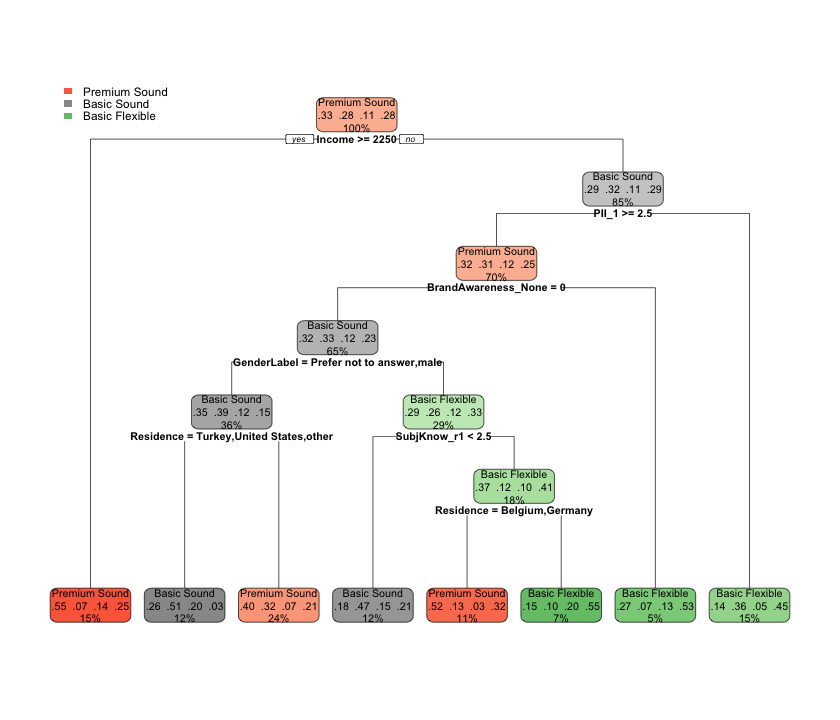

In [46]:
trimDT = prune(DT, 0.023) #Allow for 7 splits
rpart.plot(trimDT)

As assumed before a high income is now the best predictor for the Premium Sound segment. For customers with a lower income a agreement with the statement ”bluetooth speakers are unimportant” was the best predictor for the Basic Flexible Segment, followed by the feature for zero known brands. Further socio- demographic predictors for segment membership are gender and residence. Probably due to its small since, none of the end nodes is classified as Premium All-Round.

<h3>Conclusion</h3>
Four customer segments with clearly distinguishable preferences have been identified. They mainly differ in their price sensitivity and in the extent to which they value sound quality. Based on these results four products, one targeted to each customer segment, where proposed. The estimation of market shares has shown, that they all clearly outperformed the alternatives products in their respective segment. The product targeted at the Basic Sound Segment showed a very high none purchase rate even though it performed best in the full market. The segment does therefore not seem like a favourable target choice. Further analysis of customer characteristics has shown, that the Premium All-Round segment has a very low rate of people with intent to buy a speaker. Therefore and due to its small size the Premium Sound segment and the Basic Flexible segment are recommended as target groups for practitioners. The first of which can be characterized by a relative high income, a higher probability of owning a bluetooth speaker and a high domain knowledge. Also its members are more likely to be male. The Basic Flexible segment shows the opposite characteristics. A decision tree has shown that stated importances are the best predictors for segment membership in the available data set. If no stated importance data is available income, importance ratings on the product category, and residence might be used to predict segment memberships. Due to biases in the demographics of the selected respondents this results only apply for the social circle of German students. The fact that income and residence are relative good segment predictors implies, they might not generalize well on the full market population.